#  ACO ile Drone Rota Optimizasyonu
## Senaryo 8: Isparta Afet Toplanma Alanları

---

| Alan | Değer |
|------|-------|
| **Adı** | Arda |
| **Soyadı** | Özkaya |
| **Okul Numarası** | 2312721008 |
| **Ders** | BLG-307 Yapay Zeka Sistemleri |
| **GitHub Repo** | https://github.com/arda0142/ACO_Drone |

---

##  Proje Açıklaması

Bu projede **Karınca Kolonisi Optimizasyonu (Ant Colony Optimization - ACO)** algoritması kullanılarak, Isparta merkezdeki **Afet ve Acil Durum Toplanma Alanlarına** acil durum nakliye dronu için en uygun rota belirlenmektedir.

### Senaryo 8
Bir acil durum nakliye dronunun Isparta merkezde belirlenen Afet ve Acil Durum toplanma alanlarına paket taşıması için en uygun rotayı belirleyiniz.

### Kuş Uçuşu Mesafe Kullanılma Nedeni?
Drone havadan uçtuğu için yol mesafesi değil, **kuş uçuşu (Haversine)** mesafe kullanılmaktadır.

In [ ]:
!pip install pydeck

In [ ]:
# Gerekli kutuphaneler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydeck as pdk
import math
import random
from typing import List, Tuple, Dict

# Turkce karakter destegi
plt.rcParams['font.family'] = 'DejaVu Sans'

print("Kütüphaneler yüklendi!")

Kütüphaneler yüklendi!


### 📍 Proje Veri Seti (Isparta)
Senaryo 8 gereği Isparta Merkez'deki AFAD resmi verilerinden gerçek toplanma alanları ve okullar koordinat olarak tanımlanmıştır. Başlangıç noktası **Ulu Cami** olarak belirlenmiştir.

In [ ]:
# --- 18 NOKTALI  VERİ SETİ ---

TOPLANMA_ALANLARI = {
    "Isparta Ulu Camii (MERKEZ)": (37.7635, 30.5568),
    "Şehit Ferhat Çiftçi Okulu": (37.7883, 30.5492),
    "Isparta Anadolu Lisesi": (37.7859, 30.5543),
    "Kutlubey Emniyet Önü": (37.7676, 30.5533),
    "Ahmet Hilmi Yiğit Lisesi": (37.7684, 30.5547),
    "Akkent Parkı": (37.8178, 30.5781),
    "Şehit Sezgin Uludağ Okulu": (37.7679, 30.5447),
    "Bağlar Mahallesi": (37.7688, 30.5470),
    "AFAD İl Müdürlüğü": (37.7648, 30.5566),
    "Atatürk Stadyumu": (37.7595, 30.5537),
    "Kaymakkapı Meydanı": (37.7676, 30.5519),
    "15 Temmuz Demokrasi M.": (37.7632, 30.5522),
    "Gülcü Parkı": (37.7588, 30.5478),
    "SDÜ Doğu Kampüsü": (37.8456, 30.5312),
    "1500 Evler Parkı": (37.7512, 30.5598),
    "Şehir Hastanesi": (37.7892, 30.5234),
    "Davraz Yolu": (37.7734, 30.5123),
    "Ayazmana Mesire": (37.7498, 30.5712)
}

# Listelere dönüştürme (Algoritma için)
lokasyon_isimleri = list(TOPLANMA_ALANLARI.keys())
koordinatlar = list(TOPLANMA_ALANLARI.values())

print(f"✅ Veri Seti Güncellendi: Toplam {len(TOPLANMA_ALANLARI)} nokta rotaya eklendi.")

✅ Veri Seti Güncellendi: Toplam 18 nokta rotaya eklendi.


### 📐 Mesafe Hesaplama Motoru
Google Maps API alternatifi olarak, iki GPS koordinatı arasındaki kuş uçuşu mesafeyi hesaplayan matematiksel model (Haversine) kullanılmıştır.

In [ ]:
def haversine(coord1: Tuple[float, float], coord2: Tuple[float, float]) -> float:
    """
    Iki koordinat arasindaki kus ucusu mesafeyi hesapla (km)
    """
    R = 6371.0 # Dunya yaricapi (km)

    lat1, lon1 = coord1
    lat2, lon2 = coord2

    # Dereceyi radyana cevir
    lat1_rad = math.radians(lat1)
    lat2_rad = math.radians(lat2)
    delta_lat = math.radians(lat2 - lat1)
    delta_lon = math.radians(lon2 - lon1)

    # Haversine formulu
    a = (math.sin(delta_lat / 2) ** 2 +
         math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2) ** 2)

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c

# Test
mesafe = haversine(koordinatlar[0], koordinatlar[1])
print(f"Haversine fonksiyonu calisiyor!")
print(f"  Merkez -> AFAD İl Müdürlüğü: {mesafe:.3f} km ({mesafe*1000:.0f} metre)")

Haversine fonksiyonu calisiyor!
  Merkez -> AFAD İl Müdürlüğü: 2.837 km (2837 metre)


### 📊 Maliyet Matrisi (Cost Matrix)
Algoritmanın çalışabilmesi için tüm noktalar arasındaki mesafeler hesaplanarak $N \times N$ boyutunda bir matris oluşturulmuştur.

In [ ]:
def mesafe_matrisi_olustur(koordinatlar: List[Tuple[float, float]]) -> np.ndarray:
    n = len(koordinatlar)
    matris = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                matris[i][j] = haversine(koordinatlar[i], koordinatlar[j])

    return matris

# Mesafe matrisini olustur
mesafe_matrisi = mesafe_matrisi_olustur(koordinatlar)

print("Mesafe Matrisi (km):")
print("=" * 60)
# Matrisi goster
print(pd.DataFrame(mesafe_matrisi).round(3))

Mesafe Matrisi (km):
       0      1      2      3      4      5      6      7      8      9   \
0   0.000  2.837  2.500  0.550  0.575  6.321  1.171  1.044  0.146  0.522   
1   2.837  0.000  0.522  2.330  2.265  4.148  2.303  2.177  2.693  3.227   
2   2.500  0.522  0.000  2.037  1.946  4.118  2.172  2.007  2.355  2.936   
3   0.550  2.330  2.037  0.000  0.152  5.992  0.757  0.570  0.426  0.901   
4   0.575  2.265  1.946  0.152  0.000  5.865  0.881  0.678  0.434  0.994   
5   6.321  4.148  4.118  5.992  5.865  0.000  6.277  6.095  6.189  6.828   
6   1.171  2.303  2.172  0.757  0.881  6.277  0.000  0.226  1.101  1.224   
7   1.044  2.177  2.007  0.570  0.678  6.095  0.226  0.000  0.954  1.190   
8   0.146  2.693  2.355  0.426  0.434  6.189  1.101  0.954  0.000  0.642   
9   0.522  3.227  2.936  0.901  0.994  6.828  1.224  1.190  0.642  0.000   
10  0.627  2.314  2.046  0.123  0.262  6.038  0.634  0.451  0.517  0.914   
11  0.406  2.803  2.531  0.499  0.619  6.484  0.841  0.772  0.426  

### 🐜 ACO Algoritma Mimarisi ve Parametre Dinamikleri
Bu sınıf, doğadaki karıncaların yiyecek arama davranışını simüle ederek **Gezgin Satıcı Problemini (TSP)** çözer. Karıncaların bir sonraki durağı seçme olasılığı ($P_{ij}$) şu üç temel mekanizmaya dayanır:

* **🧪 Feromon İzi (Global Hafıza):** Karıncaların geçtikleri yollara bıraktığı kimyasal izdir. $\alpha$ (alpha) parametresi ile kontrol edilir; yüksek olması karıncaların "popüler" yolları seçmesini sağlar.
* **👀 Sezgisel Görünürlük (Yerel Cazibe):** Hedefe olan yakınlığın çekiciliğidir ($\eta = 1/d$). $\beta$ (beta) parametresi ile kontrol edilir; karıncanın "kısa mesafeye" olan iştahını belirler.
* **💨 Buharlaşma (Unutma Faktörü):** Her iterasyon sonunda feromonların belirli bir oranda ($\rho$) silinmesidir. Bu mekanizma, algoritmanın sürekli aynı yola saplanıp kalmasını (yerel optimum tuzağı) engeller ve yeni yolların keşfine izin verir.

In [ ]:
# ACO Parametreleri
KARINCA_SAYISI = 20
ITERASYON = 100
ALPHA = 1.0
BETA = 3.0
RHO = 0.5
Q = 100
BASLANGIC_FEROMON = 0.1

class KarincaKolonisiOptimizasyonu:
    def __init__(self, mesafe_matrisi, n_karinca=20, n_iterasyon=100,
                 alpha=1.0, beta=2.0, rho=0.5, q=100, baslangic_feromon=0.1):
        self.mesafe = mesafe_matrisi
        self.n_sehir = len(mesafe_matrisi)
        self.n_karinca = n_karinca
        self.n_iterasyon = n_iterasyon
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q = q

        self.feromon = np.full((self.n_sehir, self.n_sehir), baslangic_feromon)

        self.gorunurluk = np.zeros((self.n_sehir, self.n_sehir))
        for i in range(self.n_sehir):
            for j in range(self.n_sehir):
                if i != j and self.mesafe[i][j] > 0:
                    self.gorunurluk[i][j] = 1.0 / self.mesafe[i][j]

        self.en_iyi_rota = None
        self.en_iyi_mesafe = float('inf')
        self.mesafe_gecmisi = []

    def _sonraki_sehir_sec(self, mevcut, ziyaret_edilenler):
        ziyaret_edilmemisler = [s for s in range(self.n_sehir) if s not in ziyaret_edilenler]

        if not ziyaret_edilmemisler:
            return None

        olasiliklar = []
        for sehir in ziyaret_edilmemisler:
            tau = self.feromon[mevcut][sehir]
            eta = self.gorunurluk[mevcut][sehir]
            olasiliklar.append((tau ** self.alpha) * (eta ** self.beta))

        toplam = sum(olasiliklar)
        if toplam == 0:
            olasiliklar = [1.0 / len(ziyaret_edilmemisler)] * len(ziyaret_edilmemisler)
        else:
            olasiliklar = [p / toplam for p in olasiliklar]

        secilen = random.choices(ziyaret_edilmemisler, weights=olasiliklar, k=1)[0]
        return secilen

    def _rota_olustur(self, baslangic=0):
        rota = [baslangic]
        ziyaret_edilenler = {baslangic}
        mevcut = baslangic

        while len(ziyaret_edilenler) < self.n_sehir:
            sonraki = self._sonraki_sehir_sec(mevcut, ziyaret_edilenler)
            if sonraki is None:
                break
            rota.append(sonraki)
            ziyaret_edilenler.add(sonraki)
            mevcut = sonraki

        return rota

    def _rota_mesafesi_hesapla(self, rota):
        toplam = 0.0
        for i in range(len(rota) - 1):
            toplam += self.mesafe[rota[i]][rota[i + 1]]
        toplam += self.mesafe[rota[-1]][rota[0]]
        return toplam

    def _feromon_guncelle(self, tum_rotalar, tum_mesafeler):
        self.feromon *= (1 - self.rho)
        for rota, mesafe in zip(tum_rotalar, tum_mesafeler):
            delta = self.q / mesafe
            for i in range(len(rota) - 1):
                self.feromon[rota[i]][rota[i + 1]] += delta
                self.feromon[rota[i + 1]][rota[i]] += delta
            self.feromon[rota[-1]][rota[0]] += delta
            self.feromon[rota[0]][rota[-1]] += delta

    def optimize(self, verbose=True):
        print(" Karınca Kolonisi Optimizasyonu Başladı...")
        print("=" * 50)

        for iterasyon in range(self.n_iterasyon):
            tum_rotalar = []
            tum_mesafeler = []

            for _ in range(self.n_karinca):
                rota = self._rota_olustur(baslangic=0)
                mesafe = self._rota_mesafesi_hesapla(rota)

                tum_rotalar.append(rota)
                tum_mesafeler.append(mesafe)

                if mesafe < self.en_iyi_mesafe:
                    self.en_iyi_mesafe = mesafe
                    self.en_iyi_rota = rota.copy()

            self._feromon_guncelle(tum_rotalar, tum_mesafeler)
            self.mesafe_gecmisi.append(self.en_iyi_mesafe)

            if verbose and (iterasyon + 1) % 20 == 0:
                print(f"  İterasyon {iterasyon + 1:3d}/{self.n_iterasyon} | En İyi: {self.en_iyi_mesafe:.3f} km")

        return self.en_iyi_rota, self.en_iyi_mesafe, self.mesafe_gecmisi

print(" ACO sınıfı tanımlandı!")

 ACO sınıfı tanımlandı!


### 🚀 Simülasyonun Başlatılması
Parametreler (20 Karınca, 100 İterasyon) ile optimizasyon süreci başlatılır. Algoritma her iterasyonda feromon matrisini güncelleyerek en kısa rotayı (Global Optimum) aramaya başlar.

In [ ]:
# ACO'yu oluştur ve çalıştır
aco = KarincaKolonisiOptimizasyonu(
    mesafe_matrisi,
    n_karinca=KARINCA_SAYISI,
    n_iterasyon=ITERASYON,
    alpha=ALPHA,
    beta=BETA,
    rho=RHO,
    q=Q,
    baslangic_feromon=BASLANGIC_FEROMON
)

en_iyi_rota, en_iyi_mesafe, mesafe_gecmisi = aco.optimize(verbose=True)

# Sonuç Yazdır
print("\n EN İYİ ROTA:")
for i, idx in enumerate(en_iyi_rota):
    print(f"{i+1}. {lokasyon_isimleri[idx]}")
print(f"Toplam Mesafe: {en_iyi_mesafe:.3f} km")

 Karınca Kolonisi Optimizasyonu Başladı...
  İterasyon  20/100 | En İyi: 33.615 km
  İterasyon  40/100 | En İyi: 33.456 km
  İterasyon  60/100 | En İyi: 33.456 km
  İterasyon  80/100 | En İyi: 33.456 km
  İterasyon 100/100 | En İyi: 33.456 km

 EN İYİ ROTA:
1. Isparta Ulu Camii (MERKEZ)
2. AFAD İl Müdürlüğü
3. 15 Temmuz Demokrasi M.
4. Şehit Sezgin Uludağ Okulu
5. Bağlar Mahallesi
6. Kaymakkapı Meydanı
7. Kutlubey Emniyet Önü
8. Ahmet Hilmi Yiğit Lisesi
9. Isparta Anadolu Lisesi
10. Şehit Ferhat Çiftçi Okulu
11. Şehir Hastanesi
12. Davraz Yolu
13. SDÜ Doğu Kampüsü
14. Akkent Parkı
15. Ayazmana Mesire
16. 1500 Evler Parkı
17. Gülcü Parkı
18. Atatürk Stadyumu
Toplam Mesafe: 33.456 km


### 📈 Sonuç Analizi ve Rota Görselleştirme
Algoritmanın yakınsama grafiği ve bulunan en kısa rotanın harita üzerindeki gösterimi.

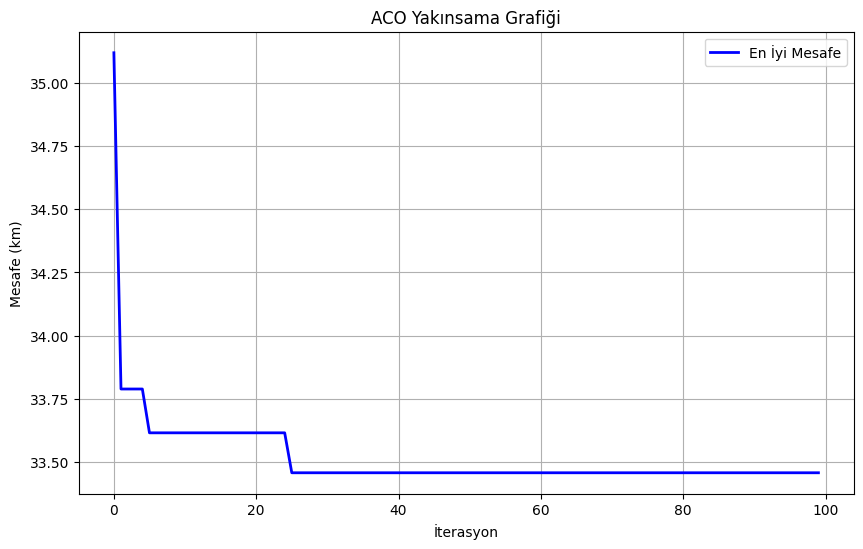

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(mesafe_gecmisi, 'b-', linewidth=2, label='En İyi Mesafe')
plt.xlabel('İterasyon')
plt.ylabel('Mesafe (km)')
plt.title('ACO Yakınsama Grafiği')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:


# Rota Çizgisi Verisi
path_data = []
for idx in en_iyi_rota:
    lat, lng = koordinatlar[idx]
    path_data.append([lng, lat])
# Rotayı kapat
start_idx = en_iyi_rota[0]
path_data.append([koordinatlar[start_idx][1], koordinatlar[start_idx][0]])

# Nokta Verisi (Renk Bilgisi Ekliyoruz)
route_points_data = []
for i, idx in enumerate(en_iyi_rota):
    # Eğer Başlangıç Noktası ise (Sıra 1) -> YEŞİL [0, 180, 0]
    # Değilse -> MAVİ [0, 100, 255]
    renk = [0, 180, 0] if i == 0 else [0, 100, 255]

    route_points_data.append({
        "lat": koordinatlar[idx][0],
        "lon": koordinatlar[idx][1],
        "name": lokasyon_isimleri[idx],
        "order": str(i + 1),
        "color": renk
    })

route_points_df = pd.DataFrame(route_points_data)

# KATMAN 1: Rota Çizgisi
layer_path = pdk.Layer(
    "PathLayer",
    data=[{"path": path_data}],
    get_color=[230, 0, 0],
    width_scale=20,
    width_min_pixels=3,
    get_path="path",
    get_width=6,
)

# KATMAN 2: Noktalar (Dinamik Renkli)
layer_points = pdk.Layer(
    "ScatterplotLayer",
    data=route_points_df,
    get_position='[lon, lat]',
    get_fill_color='color',  # Rengi veriden al
    get_radius=200,
    pickable=True,
)

# KATMAN 3: Sıra Numaraları
layer_order = pdk.Layer(
    "TextLayer",
    data=route_points_df,
    get_position='[lon, lat]',
    get_text='order',
    get_color=[255, 255, 255],
    get_size=16,
    get_alignment_baseline="'center'",
    font_weight="bold"
)

# KATMAN 4: Yer İsimleri
layer_names = pdk.Layer(
    "TextLayer",
    data=route_points_df,
    get_position='[lon, lat]',
    get_text='name',
    get_color=[0, 0, 0],
    get_size=19,
    get_alignment_baseline="'top'",
    get_pixel_offset=[0, 22],
    font_family="Arial",
    font_weight="bold"
)

# Harita Ayarları
view_state = pdk.ViewState(
    latitude=37.77,
    longitude=30.55,
    zoom=12.5,
    pitch=30,
)

deck = pdk.Deck(
    layers=[layer_path, layer_points, layer_order, layer_names],
    initial_view_state=view_state,
    tooltip={"text": "{name}\nSıra: {order}"},
    map_style="mapbox://styles/mapbox/light-v9"
)

deck.to_html("drone_route_map.html")
print("✅ Harita oluşturuldu, başlangıç noktası Isparta Ulu Camii (MERKEZ) yeşil nokta ile gösterildi.")
deck.show()

<IPython.core.display.Javascript object>

✅ Harita oluşturuldu, başlangıç noktası Isparta Ulu Camii (MERKEZ) yeşil nokta ile gösterildi.


<IPython.core.display.Javascript object>